# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계3 : Text classification

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * Machine Learning
>> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
> * Deep Learning
>> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
>> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
>> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)
>> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)

## 1. 개발 환경 설정

### 1-1. 라이브러리 설치

In [ ]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn wordcloud python-mecab-ko wget transformers

### 1-2. 라이브러리 import

In [ ]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget,os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import wget,os

In [ ]:
# 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,478 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120876 files and dire

### 1-3. 한글 글꼴 설정

In [ ]:
!sudo apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. 전처리한 데이터 불러오기
* 1, 2일차에 전처리한 데이터를 불러옵니다.
* sparse data에 대해서는 scipy.sparse.load_npz 활용

In [ ]:
import scipy

In [ ]:
x_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/미프4차_박지수/x_train_tf.npz')
x_test_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/미프4차_박지수/x_test_tf.npz')

In [ ]:
'''x_w2v_train = np.load('/content/drive/MyDrive/미프4차_박지수/X_w2v_train.npy')
x_w2v_val = np.load('/content/drive/MyDrive/미프4차_박지수/X_w2v_val.npy')
x_w2v_test = np.load('/content/drive/MyDrive/미프4차_박지수/X_w2v_te.npy')'''

In [ ]:
'''x_pr_train = np.load('/content/drive/MyDrive/미프4차_박지수/X_pr_train.npy')
x_pr_val = np.load('/content/drive/MyDrive/미프4차_박지수/X_pr_val.npy')
x_pr_test = np.load('/content/drive/MyDrive/미프4차_박지수/X_pr_te.npy')'''

In [ ]:
import numpy as np

In [ ]:
x_train_mor_seq = np.load('/content/drive/MyDrive/미프4차_박지수/x_train_seq.npy')
x_test_mor_seq = np.load('/content/drive/MyDrive/미프4차_박지수/x_test_seq.npy')

In [ ]:
y_train = np.load('/content/drive/MyDrive/미프4차_박지수/y_train.npy')

In [ ]:
from sklearn.model_selection import train_test_split

x_train_mor_seq, x_val_mor_seq, y_train, y_val = train_test_split(x_train_mor_seq, y_train, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split

x_train_tfidf, x_val_tfidf, y_train, y_val = train_test_split(x_train_tfidf, y_train, test_size=0.2, random_state=42)

ValueError: ignored

## 3. Machine Learning(N-grams)
* N-gram으로 전처리한 데이터를 이용하여 3개 이상의 Machine Learning 모델 학습 및 성능 분석
> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

### 3-1. Model 1 : 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
x_train_tfidf

<2964x10229 sparse matrix of type '<class 'numpy.float64'>'
	with 141298 stored elements in Compressed Sparse Row format>

In [ ]:
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(x_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model_1.predict(x_val_tfidf)
print(accuracy_score(y_pred, y_val))
print(classification_report(y_pred, y_val))

0.7924528301886793
              precision    recall  f1-score   support

           0       0.92      0.75      0.83       395
           1       0.68      0.83      0.75       115
           2       0.64      0.78      0.70       124
           3       0.80      0.88      0.84        92
           4       0.70      1.00      0.82        16

    accuracy                           0.79       742
   macro avg       0.75      0.85      0.79       742
weighted avg       0.81      0.79      0.80       742



In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
model = SGDClassifier(loss='log', max_iter=300)
model.fit(x_pr_train, y_train)
train_score = []
val_score = []
classes = np.unique(y_train)

for _ in range(300):
  model.partial_fit(x_pr_train, y_train, classes = classes)
  train_score.append(model.score(x_pr_train, y_train))
  val_score.append(model.score(x_pr_val, y_val))


y_pred = model.predict(x_pr_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, zero_division=0))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.7439353099730458
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       325
           1       0.68      0.62      0.65       141
           2       0.72      0.68      0.70       152
           3       0.76      0.72      0.74       101
           4       1.00      0.43      0.61        23

    accuracy                           0.74       742
   macro avg       0.78      0.66      0.70       742
weighted avg       0.75      0.74      0.74       742



In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB

In [ ]:
x_train_tfidf

<2964x10229 sparse matrix of type '<class 'numpy.float64'>'
	with 141298 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# ComplementNB 모델 생성
model = ComplementNB()

# 탐색할 하이퍼파라미터 범위 설정42
param_dist = {
    'alpha': uniform(0.01, 1),
    'fit_prior': [True, False]
}

# Randomized Search를 위한 객체 생성
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# 모델 학습 데이터 및 레이블을 여기에 제공해야 합니다.
# X_train, y_train을 실제 데이터로 바꿔야 합니다.
random_search.fit(x_train_tfidf, y_train)


# 최적의 하이퍼파라미터와 모델 성능 출력
print("최적 하이퍼파라미터:", random_search.best_params_)
print("최고 정확도:", random_search.best_score_)


최적 하이퍼파라미터: {'alpha': 0.1934347898661638, 'fit_prior': False}
최고 정확도: 0.8513176991826444


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1585
           1       0.99      1.00      0.99       732
           2       1.00      1.00      1.00       728
           3       0.99      1.00      1.00       561
           4       1.00      0.96      0.98       100

    accuracy                           1.00      3706
   macro avg       1.00      0.99      0.99      3706
weighted avg       1.00      1.00      1.00      3706



In [ ]:
model = SGDClassifier(loss='log', max_iter=300)
model.fit(x_train_tfidf, y_train)
train_score = []
val_score = []
classes = np.unique(y_train)

for _ in range(300):
  model.partial_fit(x_train_tfidf, y_train, classes = classes)
  train_score.append(model.score(x_train_tfidf, y_train))
  val_score.append(model.score(x_val_tfidf, y_val))


y_pred = model.predict(x_val_tfidf)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, zero_division=0))

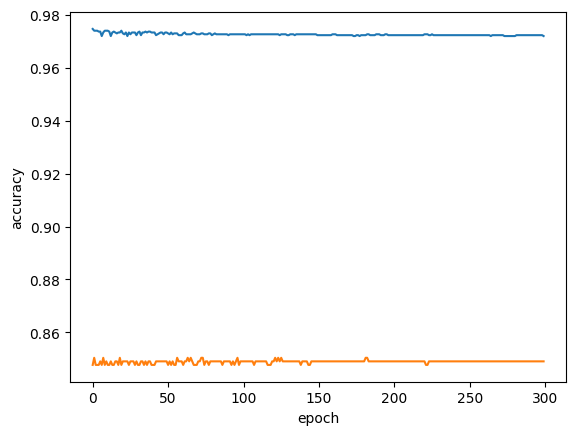

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_score)
plt.plot(val_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
y_pred_test = model.predict(x_test_tfidf)
y = pd.DataFrame({'id':range(0,len(y_pred_test)), 'label':pd.Series(y_pred_test)})
y.to_csv('y_test_pred.csv')

### 3-2. Model 2

In [ ]:
model_2 = XGBClassifier(random_state=42)
model_2.fit(x_train_tfidf, y_train)
y_pred_2 = model_2.predict(x_val_tfidf)
print(accuracy_score(y_pred_2, y_val))
print(classification_report(y_pred_2, y_val))

0.8126684636118598
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       346
           1       0.76      0.81      0.78       132
           2       0.73      0.75      0.74       148
           3       0.78      0.85      0.81        93
           4       0.96      0.96      0.96        23

    accuracy                           0.81       742
   macro avg       0.82      0.84      0.83       742
weighted avg       0.82      0.81      0.81       742



### 3-3. Model 3

In [ ]:
model_3 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, random_state=42)
model_3.fit(x_train_tfidf, y_train)
y_pred_3 = model_3.predict(x_val_tfidf)
print(accuracy_score(y_pred_3, y_val))
print(classification_report(y_pred_3, y_val))

0.8126684636118598
              precision    recall  f1-score   support

           0       0.90      0.80      0.84       364
           1       0.76      0.85      0.80       126
           2       0.70      0.75      0.73       143
           3       0.76      0.89      0.82        87
           4       0.91      0.95      0.93        22

    accuracy                           0.81       742
   macro avg       0.81      0.85      0.82       742
weighted avg       0.82      0.81      0.81       742



In [ ]:
y_pred_test = model_3.predict(x_test_tfidf)

In [ ]:
y = pd.DataFrame({'id':range(0,len(y_pred_test)), 'label':pd.Series(y_pred_test)})
y.to_csv('y_test_pred.csv')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from scipy.stats import uniform, randint

In [ ]:
#params = {'learning_rate' : uniform(0.01, 0.2), 'n_estimators':randint(100, 500)}
#gs = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), params, n_iter=15, random_state=42, n_jobs=-1)

In [ ]:
#gs.fit(x_train_tfidf, y_train)

KeyboardInterrupt: ignored

In [ ]:
print(gs.best_params_)

In [ ]:
model_3 = GradientBoostingClassifier(random_state=42)
model_3.fit(x_train_tfidf, y_train)
y_pred_3 = model_3.predict(x_val_tfidf)
print(accuracy_score(y_pred_3, y_val))
print(classification_report(y_pred_3, y_val))

In [ ]:
from sklearn.linear_model import LogisticRegression

## 4. Deep Learning(Sequence)
* Sequence로 전처리한 데이터를 이용하여 DNN, 1-D CNN, LSTM 등 3가지 이상의 deep learning 모델 학습 및 성능 분석
> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

### 4-1. DNN

In [ ]:
x_test_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
np.array(y_train)

array([0, 4, 2, ..., 3, 0, 3])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

dnn_model = Sequential()
dnn_model.add(Dense(128, input_shape=(x_train_tfidf.shape[1],), activation='relu'))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(5, activation='softmax'))
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

dnn_model.summary()
dnn_model.fit(x_train_tfidf.toarray(), np.array(y_train), epochs=50, validation_data=(x_test_tfidf.toarray(),  np.array(y_test)))

accuracy_dl = dnn_model.evaluate(x_test_tfidf.toarray(),  np.array(y_test), verbose=0)[1]
print("정확도:", accuracy_dl)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 128)               395520    
                                                                 
 dense_58 (Dense)            (None, 64)                8256      
                                                                 
 dense_59 (Dense)            (None, 32)                2080      
                                                                 
 dense_60 (Dense)            (None, 5)                 165       
                                                                 
Total params: 406021 (1.55 MB)
Trainable params: 406021 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
93/93 [==============================] - 2s 10ms/step - loss: 1.2842 - accuracy: 0.4524 - val_loss: 0.8878 - val_accuracy: 0.6927
Epoch 2/

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

# 파이토치 기능을 통한 GPU 지정
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# 가장 기본적인 분류를 위한 BERT 모델 로드
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import *
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/tokenizer.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size":

### 4-2. 1-D CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

dnn_model = Sequential()

dnn_model.add(Dense(128, input_shape=(x_train_mor_seq.shape[1],), activation='relu'))
dnn_model.add(Dropout(0.3))

dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(32, activation='relu'))

dnn_model.add(BatchNormalization())
dnn_model.add(Dense(5, activation='softmax'))

dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

dnn_model.summary()

history = dnn_model.fit(x_train_mor_seq, np.array(y_train), epochs=20,
                        validation_data=(x_test_mor_seq, np.array(y_test)),
                        callbacks=[early_stopping])

accuracy_dl2 = dnn_model.evaluate(x_test_mor_seq, np.array(y_test), verbose=0)[1]
print("정확도:", accuracy_dl2)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 128)               9728      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None, 64)                8256      
                                                                 
 dense_63 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_7 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_64 (Dense)            (None, 5)                 165       
                                                     

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout

cnn_model = Sequential()

cnn_model.add(Embedding(input_dim=x_train_tfidf.shape[1], output_dim=128, input_length=x_train_mor_seq.shape[1]))

cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

cnn_model.add(GlobalMaxPooling1D())

cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(32, activation='relu'))

cnn_model.add(Dense(5, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()
es = EarlyStopping(patience=2, restore_best_weights=True)
cnn_model.fit(x_train_mor_seq, y_train, epochs=20, validation_data=(x_val_mor_seq, y_val), callbacks=[es])

accuracy_cnn = cnn_model.evaluate(x_val_mor_seq, y_val, verbose=0)[1]
print("정확도:", accuracy_cnn)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 500, 128)          1309312   
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)          82048     
                                                                 
 global_max_pooling1d_15 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                     

### 4-3. LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()

# input_dim = 단어의 개수, output_dim = 임베딩된 벡터의 차원
model.add(Embedding(input_dim=x_train_tfidf.shape[1], output_dim=128, input_length=x_train_mor_seq.shape[1]))
# model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
# 시퀀스 데이터에서 가장 큰 값을 선택, 출력하는 연산(시퀀스 특징 추출)
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
es = EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(x_train_mor_seq, np.array(y_train), epochs=20, validation_data=(x_val_mor_seq, np.array(y_val)), callbacks=[es])

loss, accuracy_lstm = model.evaluate(x_val_mor_seq, np.array(y_val), verbose=0)
print("정확도:", accuracy_lstm)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 500, 128)          1309312   
                                                                 
 bidirectional_11 (Bidirect  (None, 500, 128)          98816     
 ional)                                                          
                                                                 
 global_max_pooling1d_11 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_22 (Dense)            (None, 32)                4128      
                                                                 
 dense_23 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1412421 (5.39 MB)
Trainable params: 141

TypeError: ignored

In [ ]:
pred_val = cnn_model.predict(x_val_mor_seq)
y_pred_val = np.argmax(pred_val, axis=1)

24/24 [==============================] - 0s 14ms/step


In [ ]:
print(classification_report(y_pred_val, y_val))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       305
           1       0.86      0.80      0.83       152
           2       0.75      0.75      0.75       153
           3       0.87      0.81      0.84       109
           4       0.96      0.96      0.96        23

    accuracy                           0.84       742
   macro avg       0.86      0.84      0.85       742
weighted avg       0.84      0.84      0.84       742



In [ ]:
test_pred = cnn_model.predict(x_test_mor_seq)
y_test_pred = np.argmax(test_pred, axis=1)

30/30 [==============================] - 1s 18ms/step


In [ ]:
y = pd.DataFrame({'id':range(0,len(y_test_pred)), 'label':pd.Series(y_test_pred)})

In [ ]:
y.to_csv('y_test_pred.csv')

In [ ]:
import matplotlib.pyplot as plt

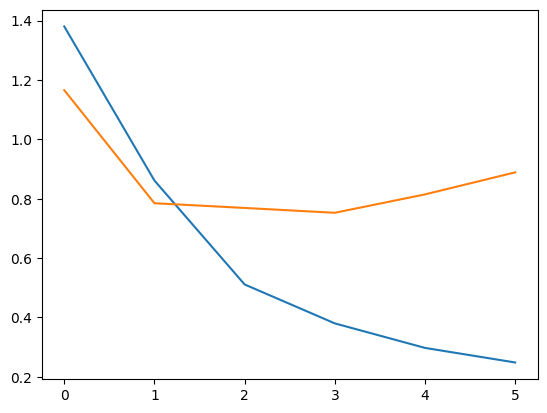

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
pred = model.predict(x_test_mor_seq)

30/30 [==============================] - 0s 14ms/step


In [ ]:
y_pred = np.argmax(pred, axis=1)

In [ ]:
y = pd.DataFrame({'id':range(0,len(y_pred)), 'label':pd.Series(y_pred)})

In [ ]:
y.to_csv('y_pred.csv')